# Static plotting for `spatialdata` 

In this notebook, we will explore how to use `spatialdata-plot` to generate static plots of various different technologies. When we load the `spatialdata-plot` library, this adds the `.pl` accessor to every `SpatialData` object, which gives us access to the plotting functions. Their logic is loosly inspired by the ggplot-library in R, in which one can chain multiple function calls, gradually building the final figure.

⚠️ Adjust the variable below to the data path on your specific workstation.

In [1]:
%load_ext jupyter_black

data_path = "../data/"

In [2]:
import spatialdata as sd
import spatialdata_plot as sdp
import matplotlib.pyplot as plt  # for multi-panel plots later
import scanpy as sc
import squidpy as sq

for p in [sd, sdp, sc, sq]:
    print(f"{p.__name__}: {p.__version__}")

sdata_visium = sd.read_zarr(data_path + "visium.zarr/")

spatialdata: 0.2.3.dev2+ga2aab25
spatialdata_plot: 0.2.3.post1.dev68+gc8b0b34
scanpy: 1.10.2
squidpy: 1.6.0


In particular, the library exposes the following functions:
- [`SpatialData.pl.render_images()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_images)
- [`SpatialData.pl.render_labels()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_labels)
- [`SpatialData.pl.render_points()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_points)
- [`SpatialData.pl.render_shapes()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_shapes)
- [`SpatialData.pl.show()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.show)

We can chain the 4 `render_xxx` functions to gradually build up a figure, with a final call to `show` to then actually render out the function. In the following sections we will explore these functions further.

## Simple function calls <a id="simple-viz"></a>
Let's first focus on some [Visium](https://www.10xgenomics.com/products/spatial-gene-expression) data from the previous notebook. As we can see below, it contains slots for `Images`, `Shapes`, and `Tables`.

In [3]:
sdata_visium

SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-workshops/data/visium.zarr
├── Images
│     ├── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image': DataArray[cyx] (3, 2000, 1744)
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image': DataArray[cyx] (3, 600, 523)
├── Shapes
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma': GeoDataFrame shape: (5756, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (5756, 18085)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma (Shapes)
    ▸ 'downscaled_lowres', with elements:
        CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma (Shapes)
    ▸ 'global', with elements:
        CytAssist_FFPE_Protein_Expression_Human_G

Let's first visualize the individual contained modalities separately. When rendering the images, we see that we get two plots. That's because the `SpatialData` object contains two coordinate systems (`downscaled_hires` and `downscaled_lowres`) with images aligned to them. The `global` coordinate system doesn't contain any, as visible above.

INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              


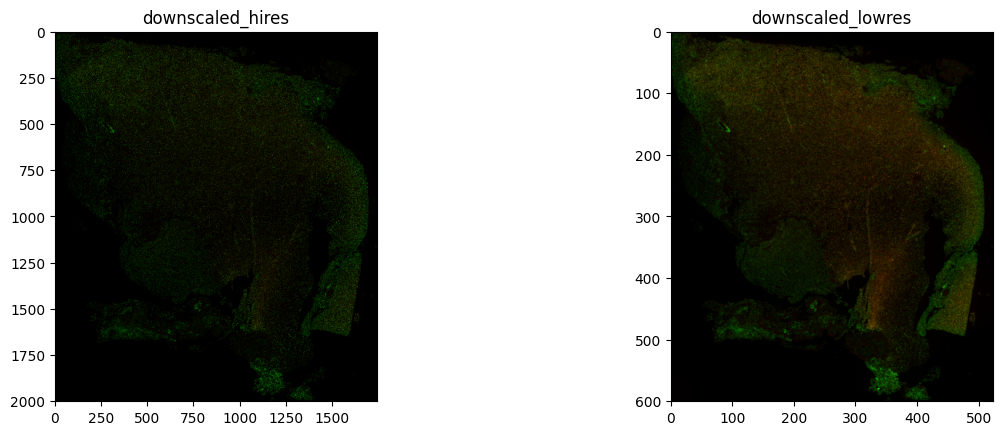

In [4]:
sdata_visium.pl.render_images().pl.show()

We can pass the name of a specific coordinate system to the `pl.show()` function to only render elements of that coordinate system.

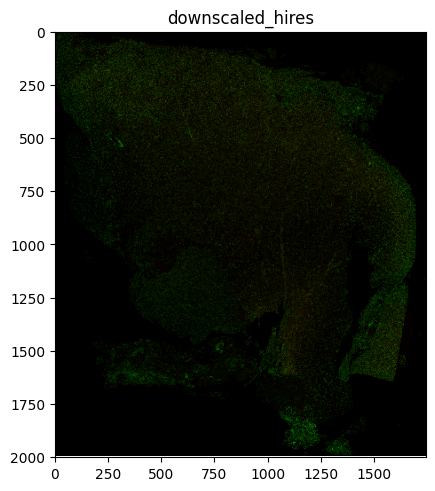

In [5]:
sdata_visium.pl.render_images().pl.show(coordinate_systems="downscaled_hires")

The Visium technology works by detecting transcripts in specific circular caption locations (often referred to as "Visium spots") on a slide. The circular capture locations are defined by the `Shapes` slot, which contains their coordinates. The `Tables` slot contains the actual transcript counts for each capture location. We can use the `render_shapes` function to overlay these circular locations onto our image.

![Visium technology](../resources/visium_tech.png)

_Image: The Visium Spatial Gene Expression Slide (https://www.10xgenomics.com/)_

INFO     Using matplotlib                                                                                          


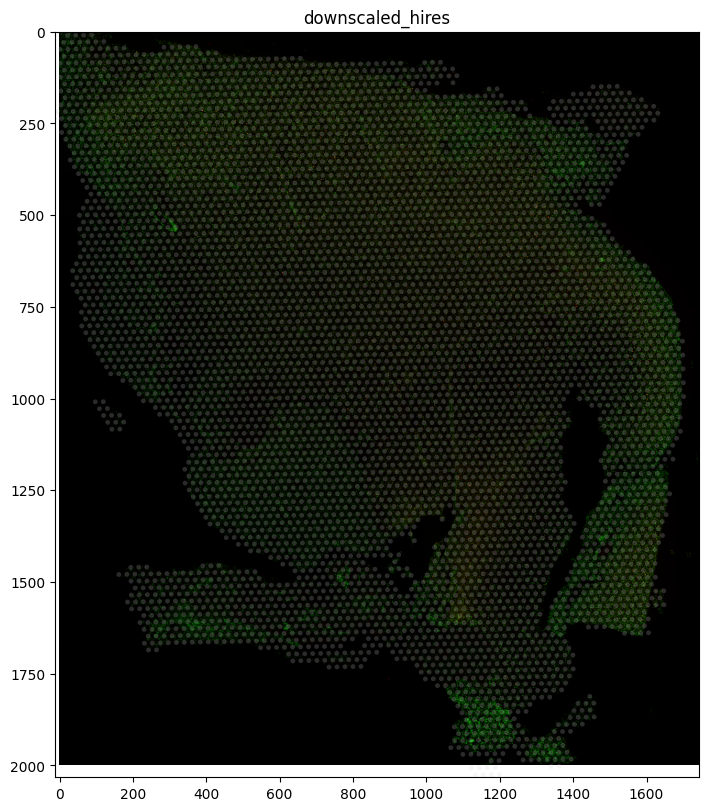

In [6]:
(
    sdata_visium.pl.render_images()
    .pl.render_shapes(fill_alpha=0.2)
    .pl.show("downscaled_hires", figsize=(8, 8))
)

## Identify some genes with spatial patterns
However, simply overlaying these locations doesn't really contain much information. Ideally we want to investigate spatial trends in the gene expression data. For this we're going to use `Squidpy`, another scverse package that contains several spatial analysis tools. We'll use it to calculate the spatial autocorrelation of some genes, more specifically Moran's I. This measure describes how homogenous a gene is expressed across a slide:

![spatial patterns](../resources/spatial_patterns.png)

_Image: https://en.wikipedia.org/wiki/Moran%27s_I_

In [7]:
adata_visium = sdata_visium.table

sq.gr.spatial_neighbors(adata_visium)
sq.gr.spatial_autocorr(
    adata_visium,
    mode="moran",
    genes=adata_visium.var_names,
    n_perms=10,
    n_jobs=1,
)
print(adata_visium.uns["moranI"].head(3))
print(adata_visium.uns["moranI"].tail(3))

/tmp/ipykernel_96441/2315337803.py:1: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  adata_visium = sdata_visium.table
/opt/miniconda3/envs/ome/lib/python3.10/site-packages/scanpy/metrics/_common.py:62: UserWarning: 43 variables were constant, will return nan for these.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
  0%|                                                                                                                       | 0/10 [00:00<?, ?/s]/opt/miniconda3/envs/ome/lib/python3.10/site-packages/scanpy/metrics/_common.py:62: UserWarning: 43 variables were constant, will return nan for these.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.33s/]


             I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
CST3  0.925848        0.0  0.000061         0.0  0.090909  0.000058   
GFAP  0.907449        0.0  0.000061         0.0  0.090909  0.000069   
IFI6  0.903449        0.0  0.000061         0.0  0.090909  0.000063   

      pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
CST3               NaN                NaN         0.106891  
GFAP               NaN                NaN         0.106891  
IFI6               NaN                NaN         0.106891  
         I  pval_norm  var_norm  pval_z_sim  pval_sim  var_sim  \
KDM5D  NaN        NaN  0.000061         NaN  0.090909      NaN   
EIF1AY NaN        NaN  0.000061         NaN  0.090909      NaN   
DAZ2   NaN        NaN  0.000061         NaN  0.090909      NaN   

        pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
KDM5D                NaN                NaN         0.106891  
EIF1AY               NaN                NaN         0.106891  
DAZ2             

Let's visualise the spatial expression of the 3 genes with the highest and lowest Moran's I scores each. We'll use classic matplotlib synthax to construct the multi-panel figure.

INFO     Using matplotlib                                                                                          
INFO     Using matplotlib                                                                                          
INFO     Using matplotlib                                                                                          
INFO     Using matplotlib                                                                                          
INFO     Using matplotlib                                                                                          
INFO     Using matplotlib                                                                                          


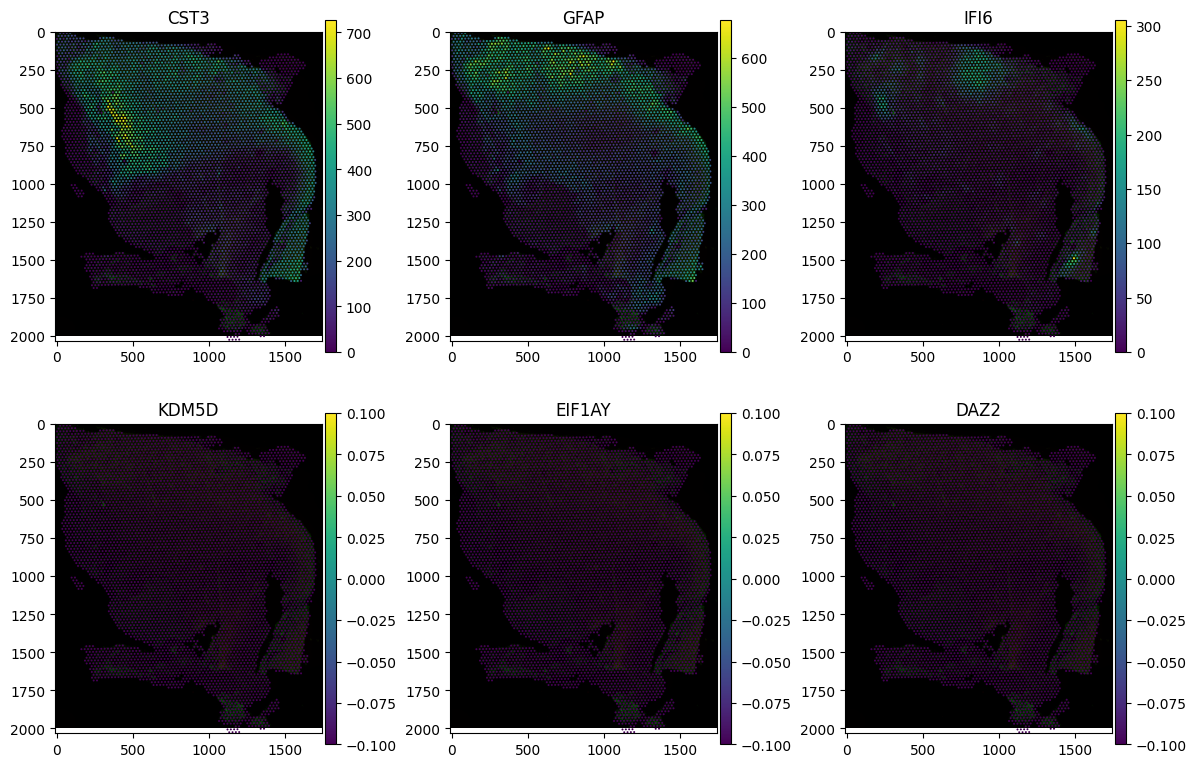

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for idx, gene in enumerate(["CST3", "GFAP", "IFI6", "KDM5D", "EIF1AY", "DAZ2"]):
    (
        sdata_visium.pl.render_images()
        .pl.render_shapes(color=f"{gene}")
        .pl.show("downscaled_hires", ax=axs[idx // 3, idx % 3], title=gene)
    )

fig.tight_layout()

Generally, the `spatialdata-plot` library tries to be as flexible as possible, allowing for a wide range of different plotting options. However, this flexibility comes at the cost of some complexity. To limit the amount of permutations we have to account for in the codebase, we recommend a workflow in which one gradually build up a figure on an `ax` object. If multiple similar plots are required, it is currently the easiest way, to manually assign them to their panels, for example like this:

INFO     Using matplotlib                                                                                          


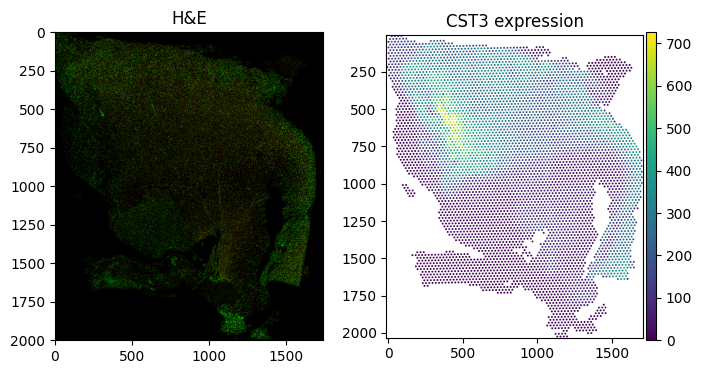

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))


sdata_visium.pl.render_images().pl.show("downscaled_hires", ax=axs[0], title="H&E")

sdata_visium.pl.render_shapes(color="CST3").pl.show(
    "downscaled_hires", ax=axs[1], title="CST3 expression"
)

## Other technology: Visum HD

The true strength of the `SpatialData` ecosystems presents itself when considering the vast amount of different technology providers on the market. Usually, most of these would require a scientist to learn specialised analysis methods and data formats. However, with `spatialdata`, we can abstract away these differences and provide a unified interface to the data. This allows us to easily switch between different technologies, without having to change the analysis code.

As a practical example of this, let's load some [Visium HD](https://www.10xgenomics.com/products/visium-hd-spatial-gene-expression) data. This technology is somewhat similar to the regular Visium technology, but the spatial expression is no longer based on an hexagonal grid but instead on probes, arranged into a square grid, which can be aggregated into different resolutions. This allows the data to have sub-cellular precision. More details can be found in the [publication](https://www.biorxiv.org/content/10.1101/2024.06.04.597233v1).

![Visium HD technology](../resources/visium_hd_tech.png)

_Image: [https://www.10xgenomics.com/blog/your-introduction-to-visium-hd-spatial-biology-in-high-definition)](https://www.10xgenomics.com/blog/your-introduction-to-visium-hd-spatial-biology-in-high-definition)_


Similarly, to the regular Visium data, we can read and inspect the individual modalities contained in the data. We can see that the `Visium HD` data contains a lot more elements in the `Shapes` slot (351817 vs 5756) due to the increased precision.

In [10]:
sdata_visium_hd = sd.read_zarr("../data/visium_hd.zarr")
sdata_visium_hd

SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-workshops/data/visium_hd.zarr
├── Images
│     ├── 'Visium_HD_Mouse_Small_Intestine_hires_image': DataArray[cyx] (3, 5575, 6000)
│     └── 'Visium_HD_Mouse_Small_Intestine_lowres_image': DataArray[cyx] (3, 558, 600)
├── Shapes
│     └── 'Visium_HD_Mouse_Small_Intestine_square_008um': GeoDataFrame shape: (351817, 1) (2D shapes)
└── Tables
      └── 'square_008um': AnnData (351817, 19059)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        Visium_HD_Mouse_Small_Intestine_hires_image (Images), Visium_HD_Mouse_Small_Intestine_square_008um (Shapes)
    ▸ 'downscaled_lowres', with elements:
        Visium_HD_Mouse_Small_Intestine_lowres_image (Images), Visium_HD_Mouse_Small_Intestine_square_008um (Shapes)
    ▸ 'global', with elements:
        Visium_HD_Mouse_Small_Intestine_square_008um (Shapes)

In [11]:
sdata_visium_hd.tables["square_008um"].var_names_make_unique()

We can use the same synthax to visualise the individual modalities contained in the data. 

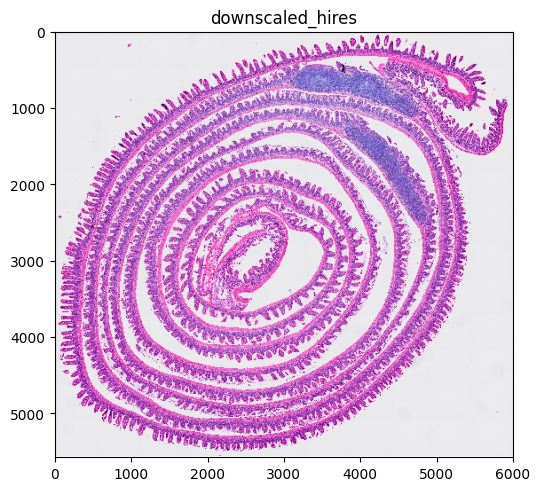

In [12]:
sdata_visium_hd.pl.render_images().pl.show("downscaled_hires")

We will use the `.query.bounding_box()` function to subset the data so that we can visually inspect the result easier. This function allows us to subset the data to a specific bounding box, which is defined by the top-left and bottom-right coordinates. This is useful when working with large datasets, as it allows us to only load the data that we're interested in.

In [13]:
sdata_visium_hd_crop = sdata_visium_hd.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[4500, 0],
    max_coordinate=[6000, 1500],
    target_coordinate_system="downscaled_hires",
)

In [14]:
sdata_visium_hd_crop.tables["square_008um"].var_names_make_unique()

Let's identify some genes with a high variance in expression across the slide for a quick proxy of Moran's I and then visualise the spatial expression of these genes.

In [15]:
sdata_visium_hd_crop.tables["square_008um"].to_df().apply(
    lambda col: col.var(), axis=0
).sort_values()

Ptpn20           0.000000
Olfr718-ps1      0.000000
Spdye4b          0.000000
Zfp853           0.000000
Pou6f2           0.000000
                  ...    
Iglc1           45.842403
Lyz1            50.397385
Defa21          58.193329
Igha           189.171158
Igkc           215.507874
Length: 19059, dtype: float32

INFO     Using matplotlib                                                                                          


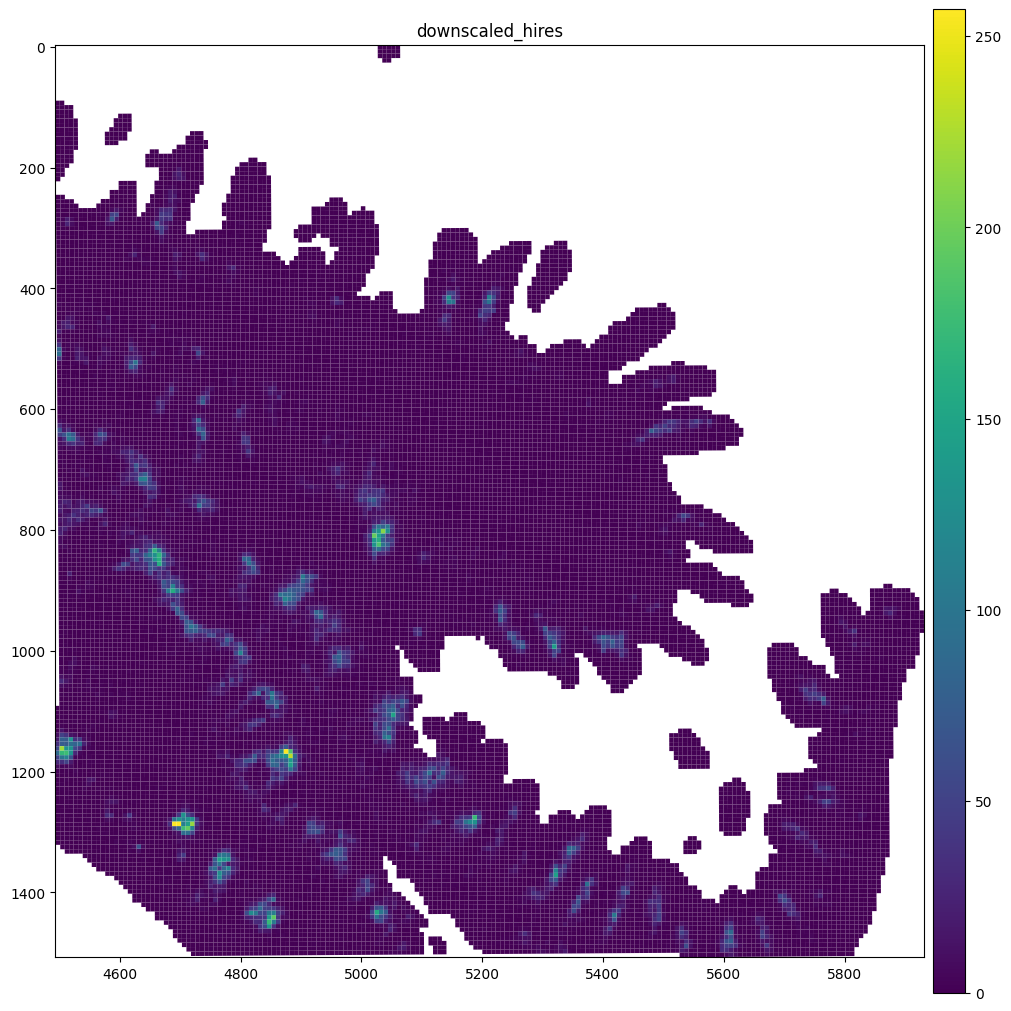

In [16]:
sdata_visium_hd_crop.pl.render_shapes(color="Igha", method="matplotlib").pl.show(
    "downscaled_hires", figsize=(10, 10)
)

We can see that these bins are continous, so when overlaying the expression over an image, we would no longer see the image. To counter this, we will modify the `colormap` we'll use so that true 0s in the expression matrix are shown fully transparent. The `spatialdata-plot` library provides a helper function for this.

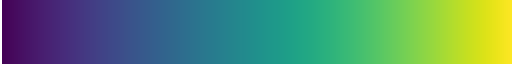

In [17]:
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent

cmap = set_zero_in_cmap_to_transparent(plt.cm.viridis)
cmap

We can now use this `cmap` to visualise the spatial expression of the genes. We see that the gene is only expressed in certain areas of the slide.

INFO     Using matplotlib                                                                                          


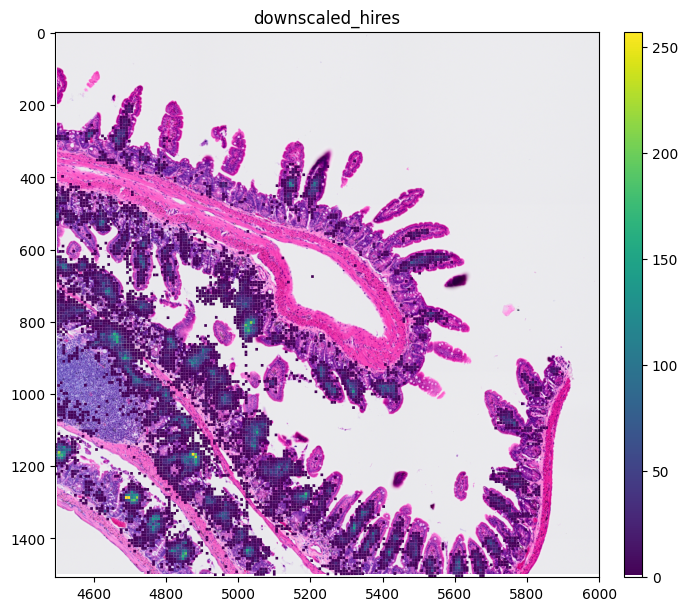

In [18]:
sdata_visium_hd_crop.pl.render_images().pl.render_shapes(
    color="Igha", method="matplotlib", cmap=cmap
).pl.show("downscaled_hires", figsize=(8, 6))

<div style="border: 1px solid #4CAF50; border-left-width: 15px; padding: 10px; background-color: #F0FFF0; color: black;">
    <strong>Tip:</strong>
    <p>Some operations, such as plotting, can be accelerated by representing the Visium HD bins as pixels of an image. The function <br><code>rasterize_bins()</code> can be used for this; for its usage please refer to the <a href="https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks/examples/technology_visium_hd.html">Visium HD notebook</a> from the documentation.</p>
</div>


## Other technology: Xenium

Similar to Visium HD, the `Xenium` technology is a spatial transcriptomics technology that allows for sub-cellular precision. The main difference is that the transcripts here are never binned and are localised with (theoretically) arbitrary precision. This allows for a much higher resolution of the data, but also makes the data much more sparse.

In [19]:
sdata_xenium = sd.read_zarr("../data/xenium.zarr")
sdata_xenium

/opt/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-workshops/data/xenium.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 5636, 1448), (3, 2818, 724), (3, 1409, 362), (3, 704, 181), (3, 352, 90)
│     └── 'morphology_focus': DataTree[cyx] (1, 17098, 51187), (1, 8549, 25593), (1, 4274, 12796), (1, 2137, 6398), (1, 1068, 3199)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
│     └── 'nucleus_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (162254, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (162254, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (156628, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (162254, 377)
with coordinate sy

We will explore this data more in detail in of our next notebooks but will use the image here to show some benefits of using the `spatialdata-plot` library with large data.

INFO     Using matplotlib                                                                                          


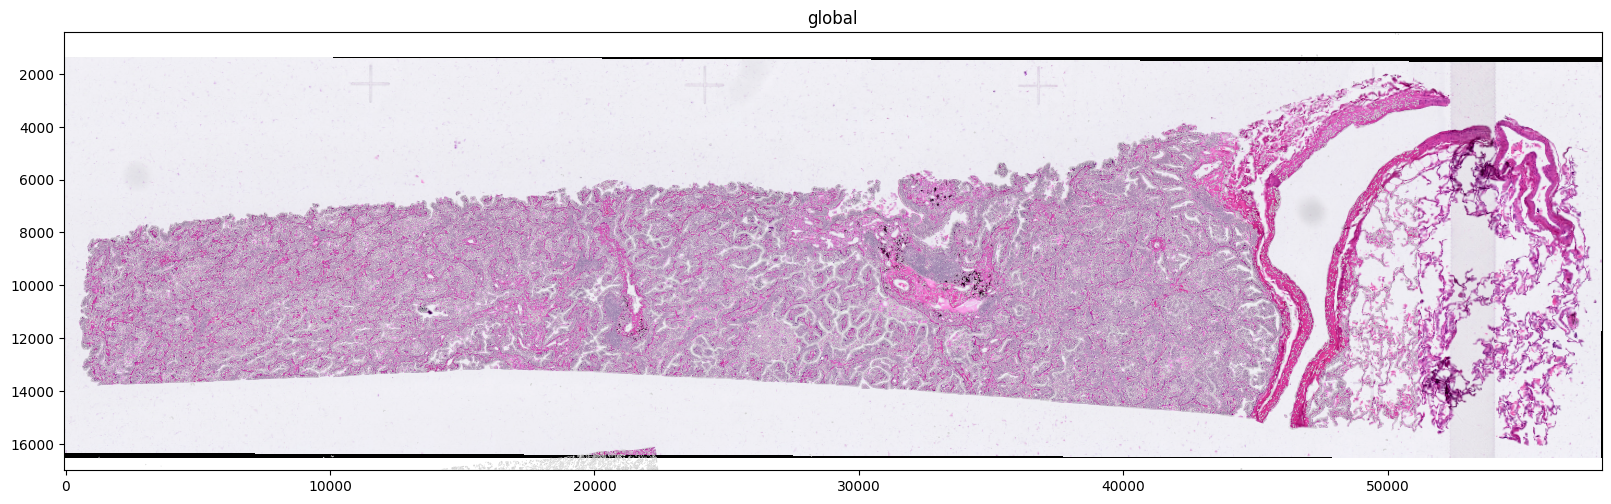

In [20]:
(
    sdata_xenium.pl.render_images("he_image")
    .pl.render_shapes("cell_boundaries", method="matplotlib")
    .pl.show("global", figsize=(16, 8))
)

## Performance improvements under the hood

Under the hood, `spatialdata-plot` performs several heuristic steps to provide the user with an image quickly. If we inspect the `morphology_focus` element, we can see that it is represented as 

> `DataTree[cyx] (1, 17098, 51187), (1, 8549, 25593), (1, 4274, 12796), (1, 2137, 6398), (1, 1068, 3199)`

This shows us that the image is stored as a pyramidal image which allows for quick access to different resolutions of the image. This is especially useful when working with large images, as it allows us to quickly inspect the image at downsampled resolution.

![image pyramid](../resources/image_pyramid.png)

_Image: https://www.researchgate.net/figure/WSI-images-are-stored-in-a-pyramidal-format-where-the-base-image-corresponds-to-the_fig2_353893643_

We can force the library to use a specific resolution by passing the `scale` argument. This will however come with increased runtime.

CPU times: user 6.21 s, sys: 4.71 s, total: 10.9 s
Wall time: 8.42 s


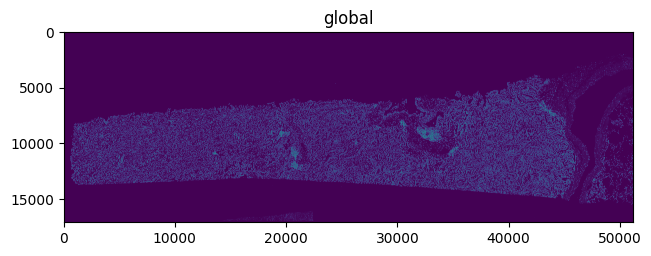

In [21]:
%%time

sdata_xenium.pl.render_images("morphology_focus", scale="full").pl.show()

Instead of manually having to pick a scale, the library automatically selects the best scale to use based on the current view.

CPU times: user 2.1 s, sys: 98 ms, total: 2.2 s
Wall time: 545 ms


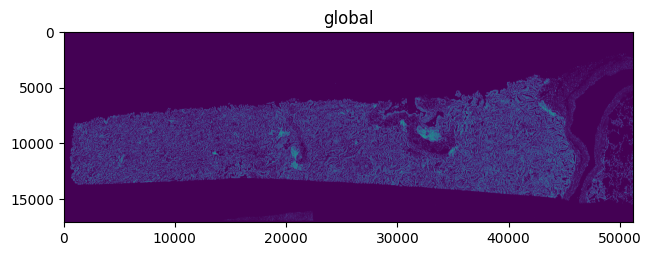

In [22]:
%%time

sdata_xenium.pl.render_images("morphology_focus").pl.show()

 We can further influence this by, for example, passing the `dpi` argument.

CPU times: user 18.7 s, sys: 968 ms, total: 19.7 s
Wall time: 3.86 s


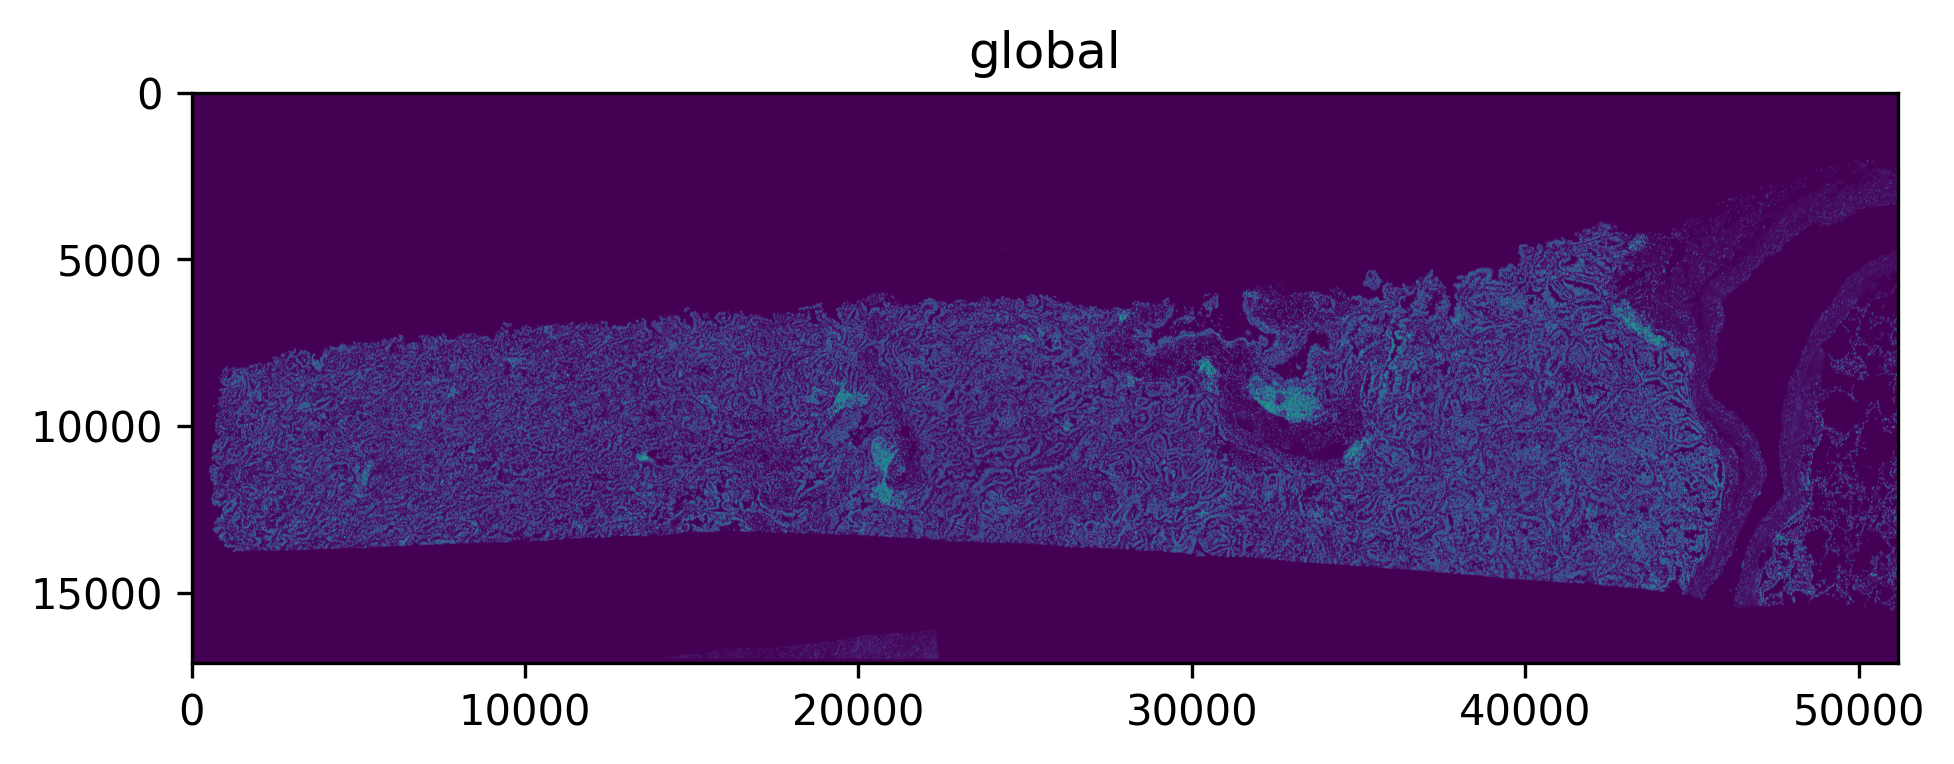

In [23]:
%%time

sdata_xenium.pl.render_images("morphology_focus").pl.show(dpi=300)

## Performance improvements for labels

CPU times: user 2.09 s, sys: 588 ms, total: 2.68 s
Wall time: 2.68 s


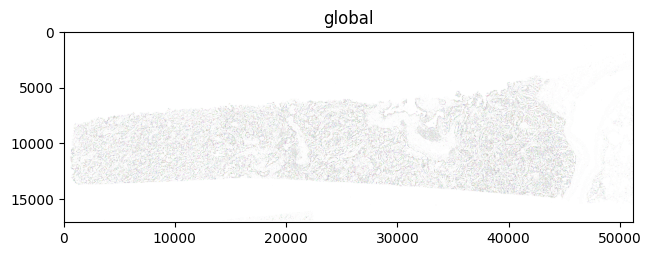

In [24]:
%%time

sdata_xenium.pl.render_labels("nucleus_labels", scale="scale3").pl.show()

CPU times: user 8.58 s, sys: 2.97 s, total: 11.5 s
Wall time: 11 s


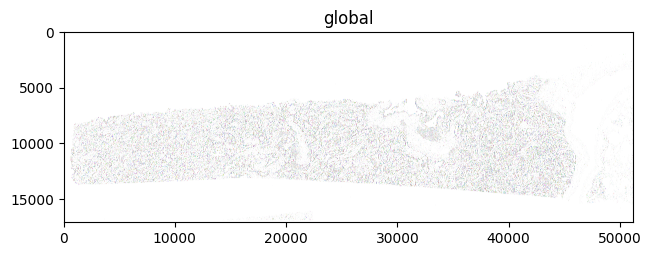

In [25]:
%%time

sdata_xenium.pl.render_labels("nucleus_labels", scale="scale2").pl.show()

CPU times: user 31.1 s, sys: 24.6 s, total: 55.8 s
Wall time: 1min 5s


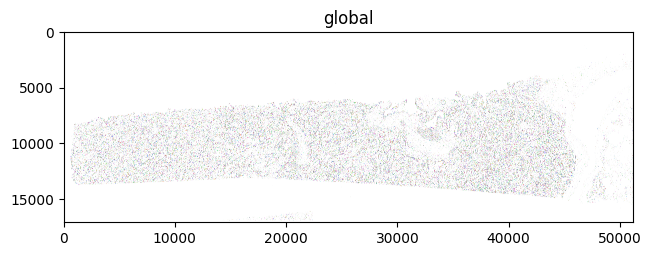

In [26]:
%%time

sdata_xenium.pl.render_labels("nucleus_labels", scale="scale1").pl.show()

In [29]:
%%time

# it takes even longer
# sdata_xenium.pl.render_labels("nucleus_labels", scale="scale0").pl.show()

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 μs
Wall time: 2.86 μs


CPU times: user 6.42 s, sys: 1.54 s, total: 7.96 s
Wall time: 6.81 s


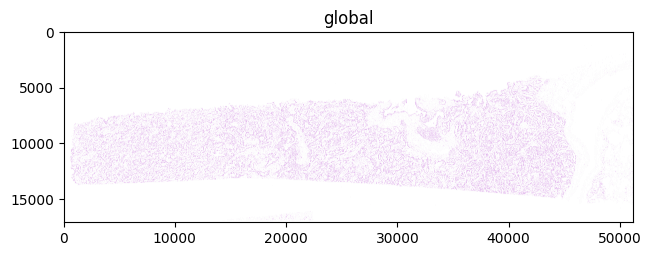

In [30]:
%%time

sdata_xenium.pl.render_labels("nucleus_labels").pl.show()